In [2]:
# python basic pacakages
import aifc
import os
import datetime
from os import listdir
from os.path import isfile, join
import csv

# required packags
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# my packages
from DataManager.Audio import *
from DataManager.General import *

In [22]:
# labels_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train.csv"
# train_path = "C:\\Users\\jorge\\DatasetsTFM\\KaggleData\\train"

labels_path = "data/train.csv"
train_path = "data/train"
redux_train_path = "data/train2"

audiofiles = [os.path.join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
audiofiles_redux = [os.path.join(redux_train_path, f) 
                    for f in listdir(redux_train_path) if isfile(join(redux_train_path, f))]

limitator = None

In [23]:
np.array([int(clip_name[-5]) for clip_name in audiofiles_redux]).sum()/len(audiofiles_redux)

0.11028197571121005

In [24]:
labels_dict = get_labels(labels_path)

# Get a random permutation to remove ordering bias
np.random.shuffle(audiofiles)

# convert the list of files to numpy arrays and select a random smaller version if limitador is not None
X_path = np.array(audiofiles)[:limitator]

# Start the process of data extraction, spectrogram transformation and data enhancement
print('Generating train and test split')
X_train_path, X_test_path = train_test_split(X_path, test_size=0.3)

print('Getting test spectrograms')
X_test, Y_test = get_spects(X_test_path, labels_dict)

# print('Getting test spectrograms')
# X_train, Y_train = get_spects(X_train_path, labels_dict)

print('Getting train spectrograms + enhancement')
X_train, Y_train = get_spects_enhanced(X_train_path, labels_dict)

print('Getting even more data adding noise to whale calls')
X_enhanced, Y_enhanced = enhance_with_noise(X_train, Y_train)

X_train, Y_train = np.concatenate([X_train, X_enhanced]), np.concatenate([Y_train, Y_enhanced])

print('Test', X_test.shape)

print('Train', X_train.shape)


Generating train and test split
Getting test spectrograms
Getting train spectrograms + enhancement
Getting even more data adding noise to whale calls
Test (9000, 40, 40)
Train (77820, 40, 40)


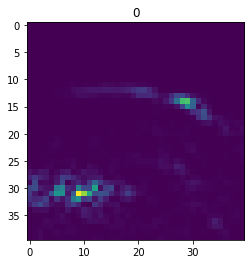

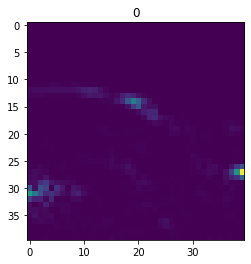

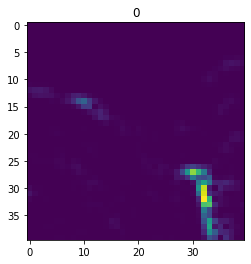

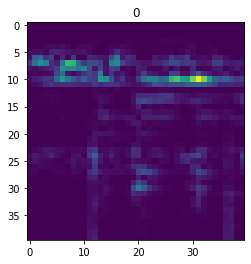

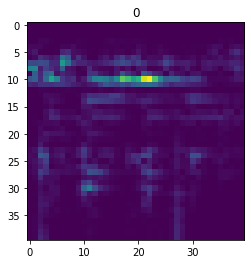

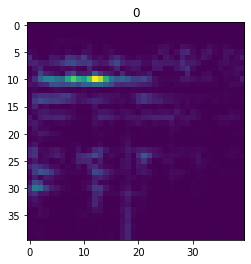

0.03140125754484214


In [25]:
def f(x):
    return x / x.max()
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break

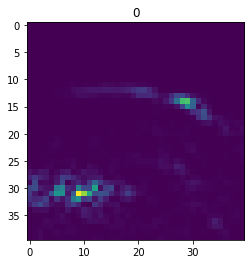

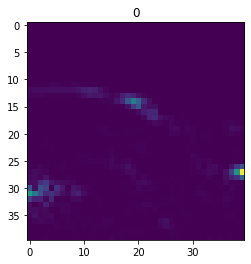

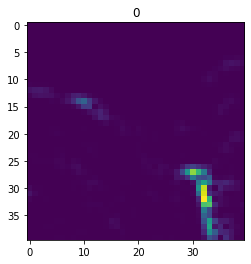

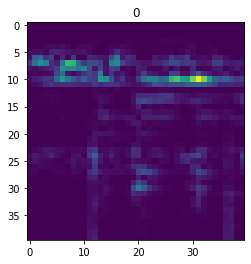

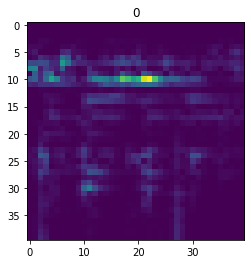

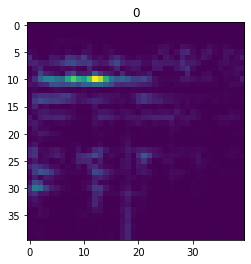

228.02283259352876


In [26]:
def f(x):
    return x
    
for i in range(X_train.shape[0]):
    n_index = i
    X_train_t = np.array(list(map(f, X_train)))
    plt.imshow(X_train_t[n_index])
    plt.title(Y_train[n_index])
    plt.show()
    if i > 4:
        print(X_train_t[n_index].mean())
        break

In [27]:
sum(list(map(int, list(labels_dict.values())[1:]))) / len(list(map(int, list(labels_dict.values())[1:]))) * 100

23.423333333333332


## Normalize small

In [50]:

def normalize_box_cox(x, a, b=1):

    if a == 0:
        return np.log(x + b)

    else:
        return ((x + b)**a - 1) / a

def f(x):
    return x / x.max()

X_train = np.array(list(map(np.log, X_train)))
X_test = np.array(list(map(np.log, X_test)))


In [54]:
print('Test: Whale %.4f, Not Whale %.4f' % ((Y_test == '1').sum() / Y_test.shape[0], 
                                            (Y_test == '0').sum() / Y_test.shape[0]))

print('Train: Whale %.4f, Not Whale %.4f' % ((Y_train == '1').sum()  / Y_train.shape[0], 
                                             (Y_train == '0').sum()  / Y_train.shape[0]) )

/scripts/WhaleClassification/tfenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


AttributeError: 'bool' object has no attribute 'sum'

In [30]:
'Tamaño en memoria de los datos de training aprox: %.2fGB' % (X_train.nbytes/2**10/2**10/2**10)

'Tamaño en memoria de los datos de training aprox: 0.93GB'

In [31]:
Y_train, Y_test = Y_train.astype(int), Y_test.astype(int)
Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, 2), tf.keras.utils.to_categorical(Y_test, 2) 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [32]:
def create_base_network(input_shape, kernel_size=(6,6), final_dimension=12, regularization=0.011):
    # model building
    model = tf.keras.models.Sequencial()
    # convolutional layer with rectified linear unit activation
    # flatten since too many dimensions, we only want a classification output
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                     activation='relu',
                     input_shape=input_shape, kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    model.add(tf.keras.models.Conv2D(1, kernel_size=kernel_size,
                    activation='relu', kernel_initializer=init,
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l1(regularization),#0.011
                bias_regularizer=regularizers.l1(regularization)))#0.011
    
    model.add(tf.keras.models.Dropout(0.5))
    # things to test in order to increase the performance of the mdel
    # play a little with the kernel sizes - test values: (6,6)
    # change the optimization function - 
    model.add(tf.keras.models.Flatten())
    # embedding sizes with better results seem to be between [8,15[
    model.add(tf.keras.models.Dense(final_dimension, activation='softmax', kernel_initializer=init,
                bias_initializer='zeros'))#13
    print(model.summary())
    return model


class siamese:
    def __init__(self, input_shape, regularization=0.011, kernel_size=(6,6), final_dimension=12, learning_rate=0.0004, margin=1.2):
        self.base_network = create_base_network(input_shape, kernel_size, final_dimension, regularization)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = self.base_network(input_a)
        processed_b = self.base_network(input_b)

        distance = Lambda(cosine_distance,  # compare this results with euclidean
                          output_shape=cos_dist_output_shape)([processed_a, 
                          processed_b])

        model = Model([input_a, input_b], distance)

        adam = Adam(lr=learning_rate)
        loss_function = contrastive_loss(margin)
        model.compile(loss=loss_function.loss, optimizer=adam, metrics=[accuracy])
        self.model = model

    def save_base_network(self, k):
        (self.base_network).save_weights("./validation_models/base_network_partition_" + str(k) + ".h5")
        
        
class winners:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(20, kernel_size=(7, 7), activation=tf.nn.relu, 
                                   input_shape=X_train.shape[1:], name='Conv1'),
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation=tf.nn.relu, name='Conv2'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation=tf.nn.relu, name="Dense1"),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax, name="Softmax")
            ])
    
class bigger:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [ ]:

opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

winners.model.compile(optimizer=opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])


print('Training model')
history = winners.model.fit(X_train, Y_train, epochs=50, verbose=2, validation_split=0.2)
score = winners.model.evaluate(X_test, Y_test)


Training model
Train on 62256 samples, validate on 15564 samples
Epoch 1/50
 - 80s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 2/50
 - 83s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 3/50
 - 78s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 4/50
 - 77s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 5/50
 - 83s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 6/50
 - 78s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 7/50
 - 80s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 8/50
 - 77s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 9/50
 - 72s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 10/50
 - 72s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.0364
Epoch 11/50
 - 72s - loss: 3.7704 - acc: 0.7648 - val_loss: 15.4463 - val_acc: 0.036

[0.4475695624616411, 0.8284444]
Finished at 2019-09-23 13:32:15.058491, saving the results as graphs.


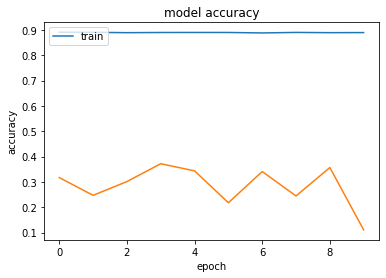

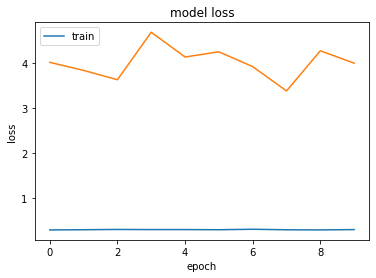

In [48]:
print(score)
print('Finished at {}, saving the results as graphs.'.format(datetime.datetime.now()))

#Accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_accuracy' + str(score[1]) + '.pdf')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# plt.savefig(save_path + tag + 'model_loss' + str(score[1]) + '.pdf')
plt.show()

In [46]:
#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import numpy as np
#Compute probabilities
Y_pred = winners.model.predict(X_test)
#Assign most probable label
y = np.argmax(Y_test, axis=1)
y_hat =  np.argmax(Y_pred, axis=1)
#Plot statistics
print('Analysis of results')
target_names = ['no_whale', 'whale']
print(classification_report(y, y_hat, target_names=target_names))
print(confusion_matrix(y, y_hat))
print(roc_auc_score(y, y_hat))

y_pred_proba = winners.model.predict_proba(X_test)[::,1]



Analysis of results
              precision    recall  f1-score   support

    no_whale       0.90      0.97      0.93      6913
       whale       0.87      0.64      0.74      2087

    accuracy                           0.89      9000
   macro avg       0.88      0.80      0.83      9000
weighted avg       0.89      0.89      0.89      9000

[[6711  202]
 [ 754 1333]]
0.8047477752622765


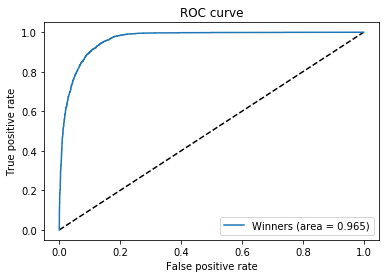

In [36]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# y_pred_proba = winners.model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label='Winners (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()